In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
%pwd

import torch
from train import load_cifar_data, get_args_parser

# device = torch.device("cpu")

device = torch.device("cuda")


args = get_args_parser().parse_args([])

args.distributed = False
args.dataset = "cifar10"
args.data_path = "./data/"
args.batch_size = 128
args.device = device

_, dataset_test, _, test_sampler = load_cifar_data(args)

num_classes = len(dataset_test.classes)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
)


/home/lprfenau/ppml-using-poly-relus/ml
Loading data
Loading training data
Files already downloaded and verified
Took 0.7329683303833008
Loading validation data
Files already downloaded and verified
Creating data loaders


In [2]:

import numpy as np
import scipy.stats

#https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

def set_dict_entry(dictionary, keys, value):
    for key in keys[:-1]:
        dictionary = dictionary.setdefault(key, {})
    dictionary[keys[-1]] = value

def dict_iterator(dictionary, keys=None):
    if keys is None:
        keys = []
    for key, value in dictionary.items():
        new_keys = keys + [key]
        if isinstance(value, dict):
            for pair in dict_iterator(value, keys=new_keys):
                yield pair
        else:
            yield [new_keys, value]

def get_CI(dictionary):
    to_return = {}
    for val in dict_iterator(dictionary):
        utilities = val[1]
        set_dict_entry(to_return, val[0], mean_confidence_interval(utilities))
    return to_return

In [3]:
degrees = []
death_epochs = {}
accuracies = {}
mean = []
lower = []
upper = []
degree = 2
num_models = 3

# first line 1 models
while True:
    try:

        death_epochs[degree] = []
        accuracies[degree] = []
        for i in range(1, num_models+1):

            output_dir = f"./experiments/figure_1/line_1/convnet_pr_degree_{degree}_{i}/"  # replace it with whatever you set as output directory
            print(output_dir)
            # we now load the checkpoint
            last_checkpoint = torch.load(output_dir+"checkpoint.pth", map_location="cpu")
            best_checkpoint = torch.load(output_dir+"best_model.pth", map_location="cpu")

            death_epochs[degree].append(last_checkpoint["epoch"])
            accuracies[degree].append(best_checkpoint["best_acc"])

        m, l, u = mean_confidence_interval(accuracies[degree])
        mean.append(m)
        lower.append(l)
        upper.append(u)
        degrees.append(degree)
        degree += 1

    except FileNotFoundError:
        break



./experiments/figure_1/line_1/convnet_pr_degree_2_1/
./experiments/figure_1/line_1/convnet_pr_degree_2_2/
./experiments/figure_1/line_1/convnet_pr_degree_2_3/
./experiments/figure_1/line_1/convnet_pr_degree_3_1/
./experiments/figure_1/line_1/convnet_pr_degree_3_2/
./experiments/figure_1/line_1/convnet_pr_degree_3_3/
./experiments/figure_1/line_1/convnet_pr_degree_4_1/
./experiments/figure_1/line_1/convnet_pr_degree_4_2/
./experiments/figure_1/line_1/convnet_pr_degree_4_3/
./experiments/figure_1/line_1/convnet_pr_degree_5_1/
./experiments/figure_1/line_1/convnet_pr_degree_5_2/
./experiments/figure_1/line_1/convnet_pr_degree_5_3/
./experiments/figure_1/line_1/convnet_pr_degree_6_1/


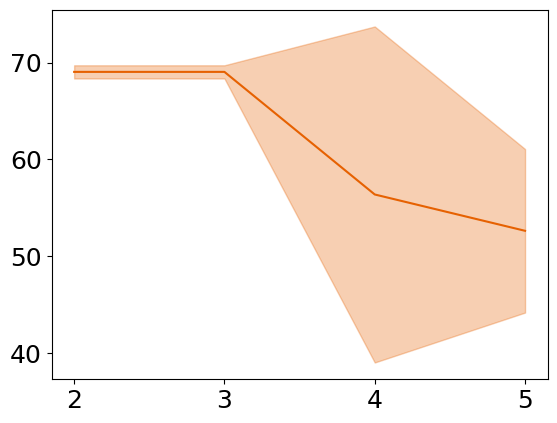

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 18})
color = "#e66101"
plt.plot(degrees, mean, label="before", color=color)
plt.fill_between(degrees, lower, upper, alpha=0.3, color=color)


In [5]:
degrees = []
mean_accuracies = {}
lower_accuracies = {}
upper_accuracies = {}

best_accuracy_index = []
best_mean = []
best_lower = []
best_upper = []
degree = 2

reg_coeffs = (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001)

done = False

while not done:
    mean_accuracies[degree] = []
    lower_accuracies[degree] = []
    upper_accuracies[degree] = []

    reg_coef_list = []

    for i, reg_coef in enumerate(reg_coeffs):
        accuracies = []

        for i in range(1, num_models+1):
            if reg_coef != 0.1:
                str_reg_coef = ("%.17f" % reg_coef).rstrip('0').rstrip('.')
            else:
                str_reg_coef = str(reg_coef)
            output_dir = f"experiments/experiment_4/convnet_pr_degree_{degree}_reg_coef_{str_reg_coef}_{i}/"  # replace it with whatever you set as output directory
            print(output_dir)
            try:
                # we now load the checkpoint
                best_checkpoint = torch.load(output_dir+"best_model.pth", map_location="cpu")
            except FileNotFoundError:
                done = True
                break

            accuracies.append(best_checkpoint["best_acc"])
            reg_coef_list.append(reg_coef)

        m, l, u = mean_confidence_interval(accuracies)
        mean_accuracies[degree].append(m)
        lower_accuracies[degree].append(l)
        upper_accuracies[degree].append(u)
    idx = np.argmax(mean_accuracies[degree])
    best_accuracy_index.append(idx)
    best_mean.append(mean_accuracies[degree][idx])
    best_lower.append(lower_accuracies[degree][idx])
    best_upper.append(upper_accuracies[degree][idx])
    degrees.append(degree)

    # done = not True in found
    if not done:
        degree += 1

experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.1_1/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.1_2/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.1_3/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.01_1/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.01_2/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.01_3/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.001_1/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.001_2/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.001_3/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.0001_1/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.0001_2/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.0001_3/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.00001_1/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.00001_2/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0.00001_3/
experiments/experiment_4/convnet_pr_degree_2_reg_coef_0

/home/lprfenau/anaconda3/envs/ppml/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lprfenau/anaconda3/envs/ppml/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[2, 3, 4, 5, 6, 7, 8, 9]
[69.04666666666667, 69.04666666666667, 56.36666666666667, 52.61000000000001, 0.0, 0.0, 0.0, 0.0]
[68.64, 67.08, 72.29, 71.73333333333333, 71.78666666666668, 72.10666666666667, 72.61666666666666, 72.92333333333333]


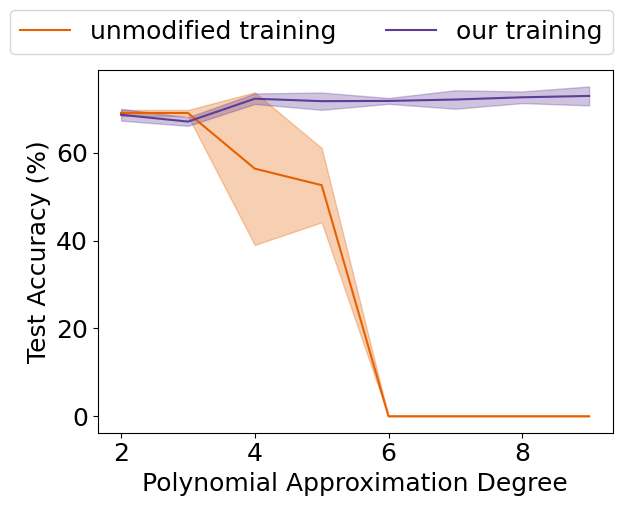

<Figure size 640x480 with 0 Axes>

In [11]:
print(degrees)
print(mean)
print(best_mean)
while len(degrees) > len(mean):
    mean.append(0.)
    lower.append(0.)
    upper.append(0.)

plt.plot(degrees, mean, label="unmodified training", color="#e66101")
plt.fill_between(degrees, lower, upper, alpha=0.3, color="#e66101")
plt.plot(degrees, best_mean, label="our training", color="#5e3c99")
plt.fill_between(degrees, best_lower, best_upper, alpha=0.3, color="#5e3c99")
plt.xlabel("Polynomial Approximation Degree")
plt.ylabel("Test Accuracy (%)")
plt.tight_layout()
plt.legend(loc="upper right", bbox_to_anchor=(1.025, 1.2), ncol=2)
plt.plot()
plt.savefig('figure_1.pdf', bbox_inches='tight')
plt.show()
plt.clf()